# Myers–Briggs Type Indicator (MBTI) Personality Prediction (For Testing Purposes Only)

## Libraries and Global Settings

In [15]:
import re
import os
import spacy
import pickle
import warnings
import numpy as np
import pandas as pd

from ipywidgets import widgets, interact
from spacy.lang.en.stop_words import STOP_WORDS
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot")

# python -m spacy download en_core_web_sm
nlp = spacy.load("en_core_web_sm")

warnings.filterwarnings('ignore')

## Data Visualization

In [2]:
if not os.path.isfile("mbti_normalized.csv"):
    df = pd.read_csv('mbti_1.csv', encoding='utf8')
else:
    df = pd.read_csv('mbti_normalized.csv', encoding='utf8')

In [3]:
df.head(10)

,Unnamed: 0,type,posts,normalized_text
0,0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,moment sportscenter play prank life change exp...
1,1,ENTP,'I'm finding the lack of me in these posts ver...,find lack post alarming sex boring position ex...
2,2,INTP,'Good one _____ https://www.youtube.com/wat...,good course know blessing curse absolutely pos...
3,3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",dear enjoy conversation day esoteric gabbe nat...
4,4,ENTJ,'You're fired.|||That's another silly misconce...,fire silly misconception approach logically ke...
5,5,INTJ,'18/37 @.@|||Science is not perfect. No scien...,Science perfect scientist claim scientific inf...
6,6,INFJ,"'No, I can't draw on my own nails (haha). Thos...",draw nail haha professional nail yes gel mean ...
7,7,INTJ,'I tend to build up a collection of things on ...,tend build collection thing desktop use freque...
8,8,INFJ,"I'm not sure, that's a good question. The dist...",sure good question distinction dependant perce...
9,9,INTP,'https://www.youtube.com/watch?v=w8-egj0y8Qs||...,position actually let person reason unfortunat...


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8675 entries, 0 to 8674
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Unnamed: 0       8675 non-null   int64 
 1   type             8675 non-null   object
 2   posts            8675 non-null   object
 3   normalized_text  8674 non-null   object
dtypes: int64(1), object(3)
memory usage: 271.2+ KB


## Preprocessing

### Text Normalization

In [5]:
def normalizer(sentence):
 
    # Remove ||| from kaggle dataset
    sentence = re.sub("[]|||[]", " ", sentence)

    # remove reddit subreddit urls
    sentence = re.sub("/r/[0-9A-Za-z]", "", sentence)

    # remove MBTI types
    MBTI_types = ['INFJ', 'ENTP', 'INTP', 'INTJ', 'ENTJ', 'ENFJ', 'INFP', 'ENFP',
              'ISFP', 'ISTP', 'ISFJ', 'ISTJ', 'ESTP', 'ESFP', 'ESTJ', 'ESFJ',
              'MBTI']
    MBTI_types = [ti.lower() for ti in MBTI_types] + [ti.lower() + 's' for ti in MBTI_types]

    tokens = nlp(sentence)

    tokens = [ti for ti in tokens if ti.lower_ not in STOP_WORDS]
    tokens = [ti for ti in tokens if not ti.is_space]
    tokens = [ti for ti in tokens if not ti.is_punct]
    tokens = [ti for ti in tokens if not ti.like_num]
    tokens = [ti for ti in tokens if not ti.like_url]
    tokens = [ti for ti in tokens if not ti.like_email]
    tokens = [ti for ti in tokens if ti.lower_ not in MBTI_types]


    # lemmatize
    tokens = [ti.lemma_ for ti in tokens if ti.lemma_ not in STOP_WORDS]
    tokens = [ti for ti in tokens if len(ti) > 1]
    
    text = " ".join(tokens)
    return text

In [6]:
if not os.path.isfile("mbti_normalized.csv"):
    df['normalized_text'] = df.posts.apply(normalizer)
    df.to_csv('mbti_normalized.csv')

In [7]:
df.head(5)

,Unnamed: 0,type,posts,normalized_text
0,0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,moment sportscenter play prank life change exp...
1,1,ENTP,'I'm finding the lack of me in these posts ver...,find lack post alarming sex boring position ex...
2,2,INTP,'Good one _____ https://www.youtube.com/wat...,good course know blessing curse absolutely pos...
3,3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",dear enjoy conversation day esoteric gabbe nat...
4,4,ENTJ,'You're fired.|||That's another silly misconce...,fire silly misconception approach logically ke...


In [8]:
# Drop unnamed columns
df = df.drop(df.columns[0], axis=1)
df = df.drop(df.columns[1], axis=1)
df

,type,normalized_text
0,INFJ,moment sportscenter play prank life change exp...
1,ENTP,find lack post alarming sex boring position ex...
2,INTP,good course know blessing curse absolutely pos...
3,INTJ,dear enjoy conversation day esoteric gabbe nat...
4,ENTJ,fire silly misconception approach logically ke...
...,...,...
8670,ISFP,IxFP think cat Fi dom reason especially websit...
8671,ENFP,thread exist someplace heck delete ooop guess ...
8672,INTP,question thing purple pill pick win lottery nu...
8673,INFP,conflicted right come want child honestly mate...


### Vectorization

In [9]:
train, test = train_test_split(df, test_size=.2)

In [10]:
train

,type,normalized_text
3095,INTJ,slightly light note curious statement regard u...
1448,INFP,child like compliment mean remind person thing...
2059,ENFP,oh man understand woman relationship man past ...
92,ISFP,money unnecessary shit like war capitalism dir...
4664,ENTP,Hahahaha guy hilarious suppose understand anyw...
...,...,...
2310,INFP,Chloe basic extreme example constantly search ...
8090,INFP,understand fluffy bunny stereotype sassy like ...
3114,INTJ,ACT read English Science Math surprised math l...
5645,ENTP,big ol' bucket depression anxiety high school ...


In [11]:
X_train = train['normalized_text']
y_train = train['type']
X_test = test['normalized_text']
y_test = test['type']

In [12]:
tf_idf = TfidfVectorizer()
X_train_tf = tf_idf.fit_transform(X_train.values.astype('U'))
X_train_tf = tf_idf.transform(X_train.values.astype('U'))

print("n_samples: %d, n_features: %d" % X_train_tf.shape)

n_samples: 6940, n_features: 81008


In [13]:
X_test_tf = tf_idf.transform(X_test.values.astype('U'))

print("n_samples: %d, n_features: %d" % X_test_tf.shape)

n_samples: 1735, n_features: 81008


In [14]:
X_train = X_train_tf
X_test = X_test_tf

## Machine Learning

In [17]:
if not os.path.isfile("model_lr.pickle"):
    # parameter grid
    parameters_lr = {
        'penalty' : ['l1', 'l2'], 
        'C'       : np.logspace(-4, 4, 20),
        'solver'  : ['newton-cg', 'lbfgs', 'liblinear'],
        'max_iter' : [50, 100, 1000, 2500, 5000]
    }

In [18]:
if not os.path.isfile("model_lr.pickle"):
    model_LR = GridSearchCV(LogisticRegression(), param_grid = parameters_lr, scoring='accuracy', cv=5)
    model_LR = model_LR.fit(X_train, y_train)
    print("\n model_LR_CON: best estimator across ALL searched params:\n",model_LR.best_estimator_)
    print("\n model_LR_CON: best parameters across ALL searched params:\n",model_LR.best_params_)


 model_LR_CON: best estimator across ALL searched params:
 LogisticRegression(C=78.47599703514607, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=50, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)

 model_LR_CON: best parameters across ALL searched params:
 {'C': 78.47599703514607, 'max_iter': 50, 'penalty': 'l2', 'solver': 'newton-cg'}


In [ ]:
if os.path.isfile("model_lr.pickle"):
    with open('model_lr.pickle', 'rb') as f:
        model_LR = pickle.load(f)
output_LR = model_LR.predict(X_test)

In [21]:
if not os.path.isfile("model_lr.pickle"):
    # Pickle the model
    with open('model_lr.pickle', 'wb') as files:
        pickle.dump(model_LR, files)

### K-Nearest Neighbors (KNN) with GridSearchCV

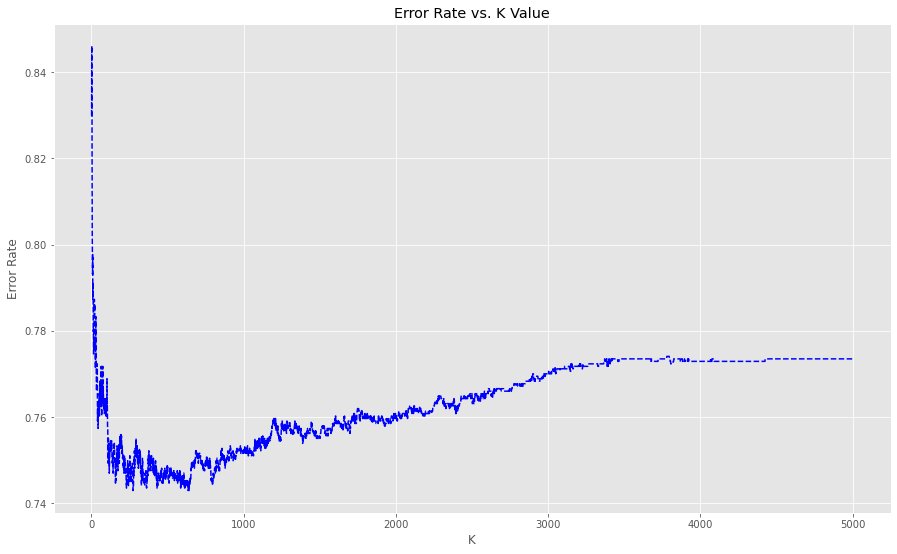

In [29]:
if not os.path.isfile("model_knn.pickle"):
    # Elbow method to determine the optimal K (n_neighbors)
    error_rate = []

    for i in range(1, 5000):
        knn = KNeighborsClassifier(n_neighbors=i)
        knn.fit(X_train, y_train)
        pred_i = knn.predict(X_test)
        error_rate.append(np.mean(pred_i != np.asarray(y_test)))

    # Plotting a Line graphs of the error rate
    plt.figure(figsize=(15,9))
    plt.plot(range(1, 5000), error_rate, color='blue', linestyle='dashed')
    plt.title('Error Rate vs. K Value')
    plt.xlabel('K')
    plt.ylabel('Error Rate')
    plt.show()

In [32]:
if not os.path.isfile("model_knn.pickle"):
    # Optimal K (n_neighbors)
    min_error = min(error_rate)
    k = error_rate.index(min_error)
    print('Optimal K (n_neighbors) = ' + str(k))
    
    # Lists of hyperparameters
    leaf_size = list(range(1, 30))
    p=[1, 2]
    weights = ['uniform', 'distance'],
    metric = ['minkowski', 'euclidean', 'manhattan']

    # Hyperparameters dictionary
    hyperparameters = dict(leaf_size=leaf_size, p=p, metric=metric)

Optimal K (n_neighbors) = 272


In [ ]:
if not os.path.isfile("model_knn.pickle"):
    # Build KNN classifier with hyperparameter tuning
    model_KNN = GridSearchCV(KNeighborsClassifier(n_neighbors=k), hyperparameters, scoring='accuracy', cv=5)
    model_KNN = model_KNN.fit(X_train, y_train)
else:
    with open('model_knn.pickle', 'rb') as f:
        model_KNN = pickle.load(f)

In [ ]:
output_KNN = model_KNN.predict(X_test)

In [ ]:
if not os.path.isfile("model_knn.pickle"):
    # Pickle the model
    with open('model_knn.pickle', 'wb') as files:
        pickle.dump(model_KNN, files)

## Evaluation

In [20]:
# Calculatingthe accuracy of the KNN model
accuracy = accuracy_score(y_test, output_LR)
accuracy

0.40576368876080693

## Example: how to use a pickled model for predictions

In [ ]:
# Example: predicting with pickled model
with open('model_knn.pickle', 'rb') as f:
    pickled_model_knn = pickle.load(f)

text = 'When I was just a little girl, I keep to myself, I hardly talk to people, even when I’m in school I don’t talk to my friends in class. Most times when my teacher ask me a question, she forces words out of my mouth. My mum told me all this.'

normalized_text = normalizer(text)
vectorized_text = tf_idf.transform([normalized_text])
prediction = pickled_model_knn.predict(vectorized_text)

prediction

## Reference
M. J, (MBTI) Myers-Briggs Personality Type Dataset, 2017, Kaggle, May 2022. [Online]. Available: https://www.kaggle.com/datasnaek/mbti-type.